# Spatial Join (Points to Polygons)

Point features can be aggregated to the polygon level. 

In [1]:
# Load relevant R packages
inLibraries = list('rgdal','raster','spdep','classInt','rgeos','repr','sp')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Crime Analysis

This time, let's look at some crime data. There are a wide variety of sources of crime data that are publically available and easy to access. For instance, I did a websearch for crime data and found the city of Chicago posts current crimes in a .csv file format (Chicago Crime data https://catalog.data.gov/dataset/crimes-one-year-prior-to-present-e171f). There are actually a large amount of crimes in this dataset, so I took a subset (those reported for Oct. 2016). I created a point featureclass from the .csv file given it contained latitude/longitude fields (chicago/ChicagoCrimeOct2016.shp)

Let's associate a polygon topology with the point crime data... US Census Tracts for the state of Illinois (https://www.census.gov/geo/maps-data/data) (chicago/centracts.shp) in this case. Also a boundary file for the study area is included (chicago/ChicagoOutlineB).

In practice, there are many workflows that can be used to aggregate point data to polygons. There are likely some R libraries that have tools that can accomplish this task rather easily.  However, it's really not a difficult task to implement and just requires understanding all of the steps invovled.  As such, let's work through this process using a logical workflow.

### Read in the crime points, tract polygons, boundary polygon featureclasses

Note the number of features of each type.

In [2]:
#Read in the crime points
inPtFeatures <- readOGR("/dsa/data/geospatial/DS8612/chicago","ChicagoCrimeOct2016")

#read in the tract polygons
inTracts <- readOGR("/dsa/data/geospatial/DS8612/chicago","centracts")

#Read in the city boundary polygons
inBoundary <- readOGR("/dsa/data/geospatial/DS8612/chicago","ChicagoOutlineB")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/chicago", layer: "ChicagoCrimeOct2016"
with 21679 features
It has 16 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/chicago", layer: "centracts"
with 1085 features
It has 194 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/chicago", layer: "ChicagoOutlineB"
with 1 features
It has 1 fields


In [4]:
head(inPtFeatures@data)

CASE_,DATE__OF_O,BLOCK,IUCR,PRIMARY_DE,SECONDARY,LOCATION_D,ARREST,DOMESTIC,BEAT,WARD,FBI_CD,X_COORDINA,Y_COORDINA,LATITUDE,LONGITUDE
HZ472453,2016/10/12,007XX W OHARE ST,1320,CRIMINAL DAMAGE,TO VEHICLE,AIRPORT EXTERIOR - SECURE AREA,N,N,1654,41,14,1096020,1938449,41.98790,-87.92221
HZ463490,2016/10/06,0000X W C17 ST,860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,N,N,1651,41,6,1099330,1935025,41.97846,-87.91010
HZ491339,2016/10/27,006XX W OHARE ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,AIRPORT EXTERIOR - NON-SECURE AREA,Y,N,1654,41,18,1100088,1926079,41.95390,-87.90747
HZ494135,2016/10/29,006XX W OHARE ST,460,BATTERY,SIMPLE,AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,N,N,1654,41,0,1100088,1926079,41.95390,-87.90747
HZ479122,2016/10/08,115XX W TOUHY AVE,890,THEFT,FROM BUILDING,AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,N,N,1654,41,6,1100260,1946117,42.00889,-87.90647
HZ464488,2016/10/02,0000X W TERMINAL ST,810,THEFT,OVER $500,AIRPORT BUILDING NON-TERMINAL - SECURE AREA,N,N,1651,41,6,1100317,1935229,41.97901,-87.90646


In [6]:
head(inTracts@data)

,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,⋯,DP0200001,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area
0,17043842800,Census Tract 8428,2426524,6842,+41.8969327,-087.9271276,4503,287,356,378,⋯,5.4,1592,1368,224,4001,465,2.92,2.08,0.09077950,0.0002640016
1,17043840703,Census Tract 8407.03,2526939,83920,+41.9372257,-087.9300599,3898,236,224,225,⋯,5.9,1644,669,975,1856,2042,2.77,2.09,0.06856793,0.0002834433
2,17043840706,Census Tract 8407.06,3215956,140418,+41.9181215,-087.9250012,3307,185,222,229,⋯,0.9,1095,985,110,2903,404,2.95,3.67,0.08234755,0.0003642677
3,17043840705,Census Tract 8407.05,4880003,12123,+41.9216340,-087.9518395,3837,263,298,251,⋯,3.4,1234,1062,172,3086,591,2.91,3.44,0.10618516,0.0005309730
4,17043840704,Census Tract 8407.04,3357971,52062,+41.9411814,-087.9472043,3258,252,229,166,⋯,9.4,1117,497,620,1345,1908,2.71,3.08,0.07947556,0.0003701992
5,17043840000,Census Tract 8400,11754772,124997,+41.9784876,-087.9395607,2999,236,220,234,⋯,2.5,867,599,268,2058,941,3.44,3.51,0.14646122,0.0012904647


In [7]:
head(inBoundary@data)

,Id
0,0


### Subset the Tract Polygons

There are many tracts that fall outside the Chicago area.  As such, select only those tracts within the bounds of Chicago to use for subsequent analysis. 

In [12]:
#Identify features that CONTAINED WITHIN Afeature
i <- 1
containedList <- list()
   
for (ele in 1:length(inTracts)){
        
    if (gContains(inBoundary, inTracts[ele,],
                      byid = FALSE, 
                      prepared = TRUE, 
                      returnDense = TRUE, 
                      STRsubset = FALSE, 
                      checkValidity = FALSE)){
        
            containedList[[i]] <- ele
            i <- i+1
        }
    }
  
contSet <- unlist(containedList)

#select the features
subTracts <- inTracts[contSet, ]

In [13]:
head(subTracts)

,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,⋯,DP0200001,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area
13,17031840300,Census Tract 8403,831224,0,+41.8320943,-087.6818822,3950,289,281,299,⋯,6.0,1173,700,473,2456,1494,3.51,3.16,0.05000424,9.009214e-05
14,17031840200,Census Tract 8402,831087,0,+41.8445748,-087.6491915,2338,166,148,131,⋯,7.8,771,408,363,1338,997,3.28,2.75,0.04752789,9.009521e-05
15,17031841100,Census Tract 8411,1143247,0,+41.8510058,-087.6350978,7254,349,316,369,⋯,4.8,2621,1039,1582,3001,4251,2.89,2.69,0.04833201,1.239465e-04
16,17031841200,Census Tract 8412,625405,0,+41.8555618,-087.6833420,5262,447,469,422,⋯,6.9,1639,444,1195,1479,3782,3.33,3.16,0.03363699,6.780896e-05
17,17031838200,Census Tract 8382,1157564,0,+41.8704157,-087.6750794,1578,57,54,38,⋯,8.0,441,143,298,374,649,2.62,2.18,0.04907786,1.255364e-04
18,17031650301,Census Tract 6503.01,985559,0,+41.7749275,-087.7299916,5711,464,511,543,⋯,3.0,1501,1176,325,4600,1104,3.91,3.40,0.04386377,1.067251e-04


### Assign Tract Polygons a Unique ID

In order to better organize the tract polygon data, it is a good idea to assign a unique index to each row of the polygon attribute dataframe. Yes, there is likely already an unique attribute for each polygon, but doing this on our own gives us more control of the process.

In [14]:
subTracts@data$uniqueid <- seq.int(nrow(subTracts@data))

In [15]:
subTracts@data$uniqueid[1:5]

[1] 1 2 3 4 5

### Create Aggregation Attributes for Burglaries and All Crime

When aggregating point data to polygons, a variable to be aggregated is required.  As the point data exist, aggregation of many of the variables would be nonsense.  For example, consider the aggregation of CASE which is the case number.  If you aggregate case number HZ472453 and HZ463490 by taking their mean value what does that give you?  What if you aggregate them by taking the first value only (i.e. HZ472453)? Exactly....doesn't help us out much right? What we'd like is the number of burglaries that occured within each tract and the number of crimes of any type that occurred within each tract.

To do this, let's create two new fields in the crime dataframe: 

a) 'NumEvent' which will be set to 1 if the crime was a burglary and 0 otherwise, and 

b) 'NumCrimes' which will be set to 1 indicating a crime was observed at that point.  

In the crime points data, there is a field 'PRIMARY_DE' which is a string attribute conveying the type of crime.  Given this field, we can select crimes classified as burglary and set the new field 'NumEvents' = 1 in those cases.

In [16]:
head(inPtFeatures@data)

CASE_,DATE__OF_O,BLOCK,IUCR,PRIMARY_DE,SECONDARY,LOCATION_D,ARREST,DOMESTIC,BEAT,WARD,FBI_CD,X_COORDINA,Y_COORDINA,LATITUDE,LONGITUDE
HZ472453,2016/10/12,007XX W OHARE ST,1320,CRIMINAL DAMAGE,TO VEHICLE,AIRPORT EXTERIOR - SECURE AREA,N,N,1654,41,14,1096020,1938449,41.98790,-87.92221
HZ463490,2016/10/06,0000X W C17 ST,860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,N,N,1651,41,6,1099330,1935025,41.97846,-87.91010
HZ491339,2016/10/27,006XX W OHARE ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,AIRPORT EXTERIOR - NON-SECURE AREA,Y,N,1654,41,18,1100088,1926079,41.95390,-87.90747
HZ494135,2016/10/29,006XX W OHARE ST,460,BATTERY,SIMPLE,AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,N,N,1654,41,0,1100088,1926079,41.95390,-87.90747
HZ479122,2016/10/08,115XX W TOUHY AVE,890,THEFT,FROM BUILDING,AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,N,N,1654,41,6,1100260,1946117,42.00889,-87.90647
HZ464488,2016/10/02,0000X W TERMINAL ST,810,THEFT,OVER $500,AIRPORT BUILDING NON-TERMINAL - SECURE AREA,N,N,1651,41,6,1100317,1935229,41.97901,-87.90646


In [17]:
#create two new variables for the point data
inPtFeatures@data$NumEvents <- ifelse(inPtFeatures@data$PRIMARY_DE == 'BURGLARY', 1, 0)
inPtFeatures@data$NumCrimes <- 1

head(inPtFeatures@data, n = 3)

CASE_,DATE__OF_O,BLOCK,IUCR,PRIMARY_DE,SECONDARY,LOCATION_D,ARREST,DOMESTIC,BEAT,WARD,FBI_CD,X_COORDINA,Y_COORDINA,LATITUDE,LONGITUDE,NumEvents,NumCrimes
HZ472453,2016/10/12,007XX W OHARE ST,1320,CRIMINAL DAMAGE,TO VEHICLE,AIRPORT EXTERIOR - SECURE AREA,N,N,1654,41,14,1096020,1938449,41.98790,-87.92221,0,1
HZ463490,2016/10/06,0000X W C17 ST,860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,N,N,1651,41,6,1099330,1935025,41.97846,-87.91010,0,1
HZ491339,2016/10/27,006XX W OHARE ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,AIRPORT EXTERIOR - NON-SECURE AREA,Y,N,1654,41,18,1100088,1926079,41.95390,-87.90747,0,1


### Associate Crime Points with a Polygon

Next, let's tag each point with the polygon in which it falls.  The over() function we have used before can be used to accomplish this task. Note the format of the output of this function...what is it exactly?  It's not spatialpoints, but rather a list of the attributes of the polygons feature associated with each point.  See how the number of resulting rows is equal to the number of point features? So now, we know the polygon that is associated with each point!

In [18]:
#Identify features that INTERSECT the selected feature
BurglaryTracts <- over(inPtFeatures, subTracts)
nrow(BurglaryTracts)
head(BurglaryTracts, n = 3)

[1] 21679

GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,⋯,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area,uniqueid
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17031980000,Census Tract 9800,19680343,360284,+41.9794881,-087.9024050,0,0,0,0,⋯,0,0,0,0,0,0,0,0.2226799,0.002177072,641
17031980000,Census Tract 9800,19680343,360284,+41.9794881,-087.9024050,0,0,0,0,⋯,0,0,0,0,0,0,0,0.2226799,0.002177072,641


### Linking Points with Polygons

While in the previous step, we derived a table that associates the point features with a polygon, we still need to actually link the point dataset with the polygon attribute.  

For each point feature, we can now create two new attributes. 

1) 'tractid' which will be set to the id of the associated Census tract that was linked to the point. 

2) 'uniqueid' which will be set to the 'uniqueid' that we attributed to the tract polygons earlier on. 

Examine the attributes of the updated point dataset.

In [19]:
#configure new variables
inPtFeatures@data$utrackid <- BurglaryTracts$uniqueid
head(inPtFeatures@data, n = 3)

CASE_,DATE__OF_O,BLOCK,IUCR,PRIMARY_DE,SECONDARY,LOCATION_D,ARREST,DOMESTIC,BEAT,WARD,FBI_CD,X_COORDINA,Y_COORDINA,LATITUDE,LONGITUDE,NumEvents,NumCrimes,utrackid
HZ472453,2016/10/12,007XX W OHARE ST,1320,CRIMINAL DAMAGE,TO VEHICLE,AIRPORT EXTERIOR - SECURE AREA,N,N,1654,41,14,1096020,1938449,41.98790,-87.92221,0,1,NA
HZ463490,2016/10/06,0000X W C17 ST,860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,N,N,1651,41,6,1099330,1935025,41.97846,-87.91010,0,1,641
HZ491339,2016/10/27,006XX W OHARE ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,AIRPORT EXTERIOR - NON-SECURE AREA,Y,N,1654,41,18,1100088,1926079,41.95390,-87.90747,0,1,641


### Configure Data for Aggregation

Now that the point data has been attributed with the associated polygons, we can begin to think about the aggregation process. We could proceed with aggregating the point featureclass data directly, but it contains a lot of different variables that are not really important for aggregation. As such, let's first select only a subset of attributes of the point dataframe that we can use in the aggregation process.  In this case, only the tractid, NumEvents, NumCrimes, and uniqueid fields are retained.

In [20]:
#create a simplified dataset
retainedvariables <- c("NumEvents", "NumCrimes", "utrackid")
polyevents <- inPtFeatures@data[retainedvariables]
nrow(polyevents)
head(polyevents)

polyevents[] <- lapply(polyevents, function(x) type.convert(as.character(x)))

[1] 21679

NumEvents,NumCrimes,utrackid
0,1,NA
0,1,641
0,1,641
0,1,641
0,1,NA
0,1,641


### Aggregate Dataframe

Now we can aggregate the simplified dataframe based on the tract associated with the point features using the aggregate() function. The field utractid references the id for the tract. Thus, points having the same utrackid value can be aggregated.  In this case, the sum function is applied to all other attributes. Thus, aggregating NumCrime will result in the total sum of the crimes in each polygon and NumEvents will be the total number of burglaries in each polygon. Examine the structure of the output of this proceedure. Note the Group.1 column will reflect the unique tract to which the points were aggregated and you should be able to relate it back with the uniqueid of the relative tract.

In [21]:
#aggregate data
aggregateevents <- aggregate(polyevents, by = list(polyevents$utrackid), FUN = sum)
head(aggregateevents, n = 3)

Group.1,NumEvents,NumCrimes,utrackid
1,0,17,17
2,0,9,18
3,0,37,111


### Linking the Aggregate Data to the Tract Data

At this point, the aggregated data need to be linked back to the appropriate tract. In this case, the merge() function is used to associate the Group.1 column of the aggregated data to the GEOID10 column of the tract polygons. Examine the structure of the output.

In [22]:
#merge aggregate data to tract polygons
BTracts <- merge(subTracts@data, aggregateevents, by.x = "uniqueid", by.y = "Group.1", all = TRUE)
head(BTracts, n = 3)

uniqueid,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,⋯,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area,NumEvents,NumCrimes,utrackid
1,17031840300,Census Tract 8403,831224,0,+41.8320943,-087.6818822,3950,289,281,⋯,473,2456,1494,3.51,3.16,0.05000424,9.009214e-05,0,17,17
2,17031840200,Census Tract 8402,831087,0,+41.8445748,-087.6491915,2338,166,148,⋯,363,1338,997,3.28,2.75,0.04752789,9.009521e-05,0,9,18
3,17031841100,Census Tract 8411,1143247,0,+41.8510058,-087.6350978,7254,349,316,⋯,1582,3001,4251,2.89,2.69,0.04833201,1.239465e-04,0,37,111


### Sort the Merged Data

Personally, I don't care for the merge() function given that it's output can be re-organized differently from the input. That is, the order of the merged tracts is different from the order of the tracts in the polygon dataset which makes directly linking them difficult.  However, this issue is easy to solve by sorting the output. Let's sort the output using the order() function based on the uniqueid attribute that we gave the tracts earlier.

In [23]:
#sort the merged data so it aligns with the order of the tract polygons.
orderedTracts <- BTracts[order(BTracts$uniqueid), ]
head(orderedTracts, n = 3)

uniqueid,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,⋯,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area,NumEvents,NumCrimes,utrackid
1,17031840300,Census Tract 8403,831224,0,+41.8320943,-087.6818822,3950,289,281,⋯,473,2456,1494,3.51,3.16,0.05000424,9.009214e-05,0,17,17
2,17031840200,Census Tract 8402,831087,0,+41.8445748,-087.6491915,2338,166,148,⋯,363,1338,997,3.28,2.75,0.04752789,9.009521e-05,0,9,18
3,17031841100,Census Tract 8411,1143247,0,+41.8510058,-087.6350978,7254,349,316,⋯,1582,3001,4251,2.89,2.69,0.04833201,1.239465e-04,0,37,111


### Add Aggregated Attributes to Tract Polygons

Now that the aggregated data has been linked back to each tract, let's create a new variable in the tract dataset to reflect the number of burglaries and number of total crimes that occured within each tract.  We can also add another variable that reflects the burglary rate per tract (burglaries in tract /total number of crimes in tract). Note that division by zero or null values was not an issue here, but could be if this task was implemented as part of a larger workflow. For example what might happen if some of the rows were set to NA (a logical value) in one iteration and then were to be set to a number in another iteration...R probably wouln't care for that I'm guessing.

In [24]:
#compute new variables
subTracts@data$NumBurglary <- orderedTracts$NumEvents
subTracts@data$NumCrimes <- orderedTracts$NumCrimes
subTracts@data$BurglaryRate <- subTracts@data$NumBurglary/subTracts@data$NumCrimes

### Visualize the Aggregate Data

Map the computed burglary rate.

Warning message in classIntervals(subTracts@data$BurglaryRate, numcat, style = "kmeans"):
“var has missing values, omitted in finding classes”

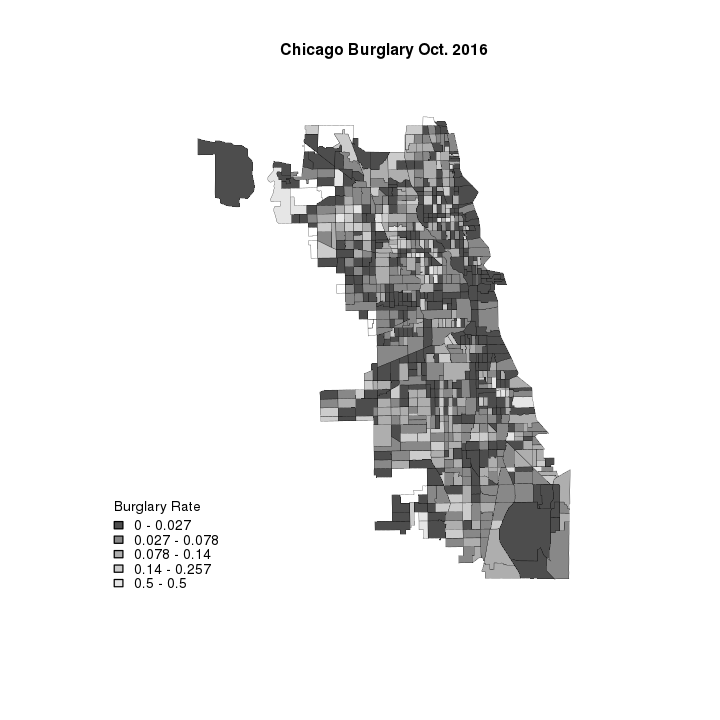

In [26]:
#classify the variable
numcat <- 5
cate <- classIntervals(subTracts@data$BurglaryRate, numcat, style="kmeans")

#plot the variable
pal1 <- gray.colors(numcat)
cols <- findColours(cate, pal1)
plot(subTracts, col = cols, lwd = 0.2, main = "Chicago Burglary Oct. 2016", cex.main = 0.8)
brks <- round(cate$brks, 3)
leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")
legend("bottomleft", fill = attr(cols,"palette"), legend = leg.text, bty = "n", title = "Burglary Rate", cex = 0.7)